# 1. Project Overview

# MCP-Powered Multi-Agent Air Quality Reasoning System — Data Preparation

This notebook prepares the **Air Pollution Image Dataset (India & Nepal)** as part of a broader  
**MCP-powered Multi-Agent Air Quality Reasoning System**.

## Dataset Overview
The dataset contains:
- Street-level images captured across urban and semi-urban locations in India and Nepal
- Corresponding sensor-based air quality measurements (PM2.5, PM10, NO₂, SO₂, CO, O₃)
- Discrete Air Quality Index (AQI) categories representing pollution severity

Each image reflects real-world atmospheric conditions such as haze, smog density, and visibility loss that correlate with pollution levels.

The dataset is organized around six AQI categories:
- Good  
- Moderate  
- Unhealthy for Sensitive Groups  
- Unhealthy  
- Very Unhealthy  
- Severe  

These classes represent increasing health risk and environmental degradation.

## System Objective
This project is part of a **Multi-Agent Reasoning System** designed to:
- Perceive air quality from heterogeneous data sources
- Reason about pollution severity and health risk
- Support decision-making for environmental monitoring and public awareness

The agents in the system include:
- **Perception Agent** — extracts visual features from images using CNNs  
- **Sensor Agent** — analyzes tabular pollutant measurements  
- **Reasoning Agent** — combines perceptual and numerical evidence to infer AQI severity  
- **Explanation Agent** — provides human-interpretable justification of predictions  

This notebook focuses on the **Perception Agent’s data pipeline** — preparing image data for robust and unbiased learning.

## Goals of This Notebook
- Load and validate the air pollution image dataset
- Build consistent image paths from metadata
- Clean and verify image integrity
- Split data into training and validation sets
- Apply appropriate preprocessing and augmentation
- Visualize dataset characteristics and potential biases
- Prepare PyTorch DataLoaders for downstream agents

## Final Goal
The final objective is to enable the system to **perceive and reason about air quality visually**, complementing sensor-based measurements and supporting explainable, multi-modal environmental intelligence.


# 2. Imports & Setup

In [43]:
import os
import random
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split


# 3. Download & Load Dataset

In [44]:
# Download dataset
path = kagglehub.dataset_download("adarshrouniyar/air-pollution-image-dataset-from-india-and-nepal")

ROOT = os.path.join(path, "Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset")
IMAGE_ROOT = os.path.join(ROOT, "IND_and_NEP")

# Load metadata CSV
df = pd.read_csv(os.path.join(ROOT, "IND_and_Nep_AQI_Dataset.csv"))
df.head()


Using Colab cache for faster access to the 'air-pollution-image-dataset-from-india-and-nepal' dataset.


,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-9.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
1,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-8.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
2,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-7.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
3,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-6.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
4,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-5.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy


# 4. Dataset Inspection

In [45]:
df.shape, df.columns


((12240, 14),
 Index(['Location', 'Filename', 'Year', 'Month', 'Day', 'Hour', 'AQI', 'PM2.5',
        'PM10', 'O3', 'CO', 'SO2', 'NO2', 'AQI_Class'],
       dtype='object'))

In [46]:
df["AQI_Class"].value_counts()


,count
AQI_Class,
c_Unhealthy_for_Sensitive_Groups,2863
d_Unhealthy,2622
e_Very_Unhealthy,2194
b_Moderate,1573
a_Good,1541
f_Severe,1447


# 5. Build Image Paths & Labels

In [47]:
df["image_path"] = IMAGE_ROOT + "/" + df["AQI_Class"] + "/" + df["Filename"]

class_map = {
    "a_Good": 0,
    "b_Moderate": 1,
    "c_Unhealthy_for_Sensitive_Groups": 2,
    "d_Unhealthy": 3,
    "e_Very_Unhealthy": 4,
    "f_Severe": 5
}
df["label"] = df["AQI_Class"].map(class_map)


# 6. Validate Image Paths

In [48]:
df["image_path"].apply(os.path.exists).value_counts()


,count
image_path,
True,12240


# 7. Train / Validation Split

In [49]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)


# 8. Data Augmentation & Preprocessing

In [50]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# 9. Custom Dataset Class

In [51]:
class AQIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df["image_path"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


# 10. Create DataLoaders

In [52]:
train_dataset = AQIDataset(train_df, transform=train_transforms)
val_dataset = AQIDataset(val_df, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# 11. Class Distribution

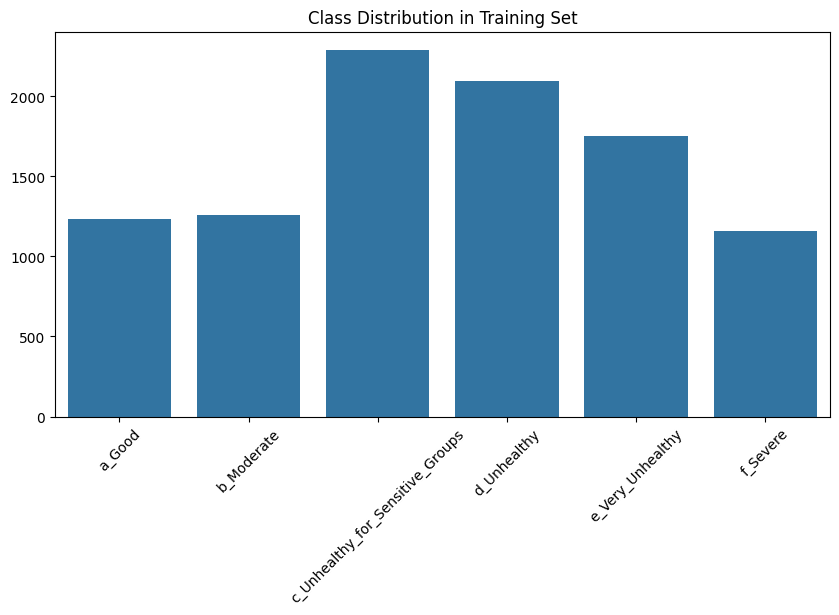

In [53]:
class_counts = train_df["label"].value_counts().sort_index()
inv_class_map = {v: k for k, v in class_map.items()}
class_names = [inv_class_map[i] for i in class_counts.index]

plt.figure(figsize=(10,5))
sns.barplot(x=class_names, y=class_counts.values)
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Set")
plt.show()


# 12. Visualize Sample Images

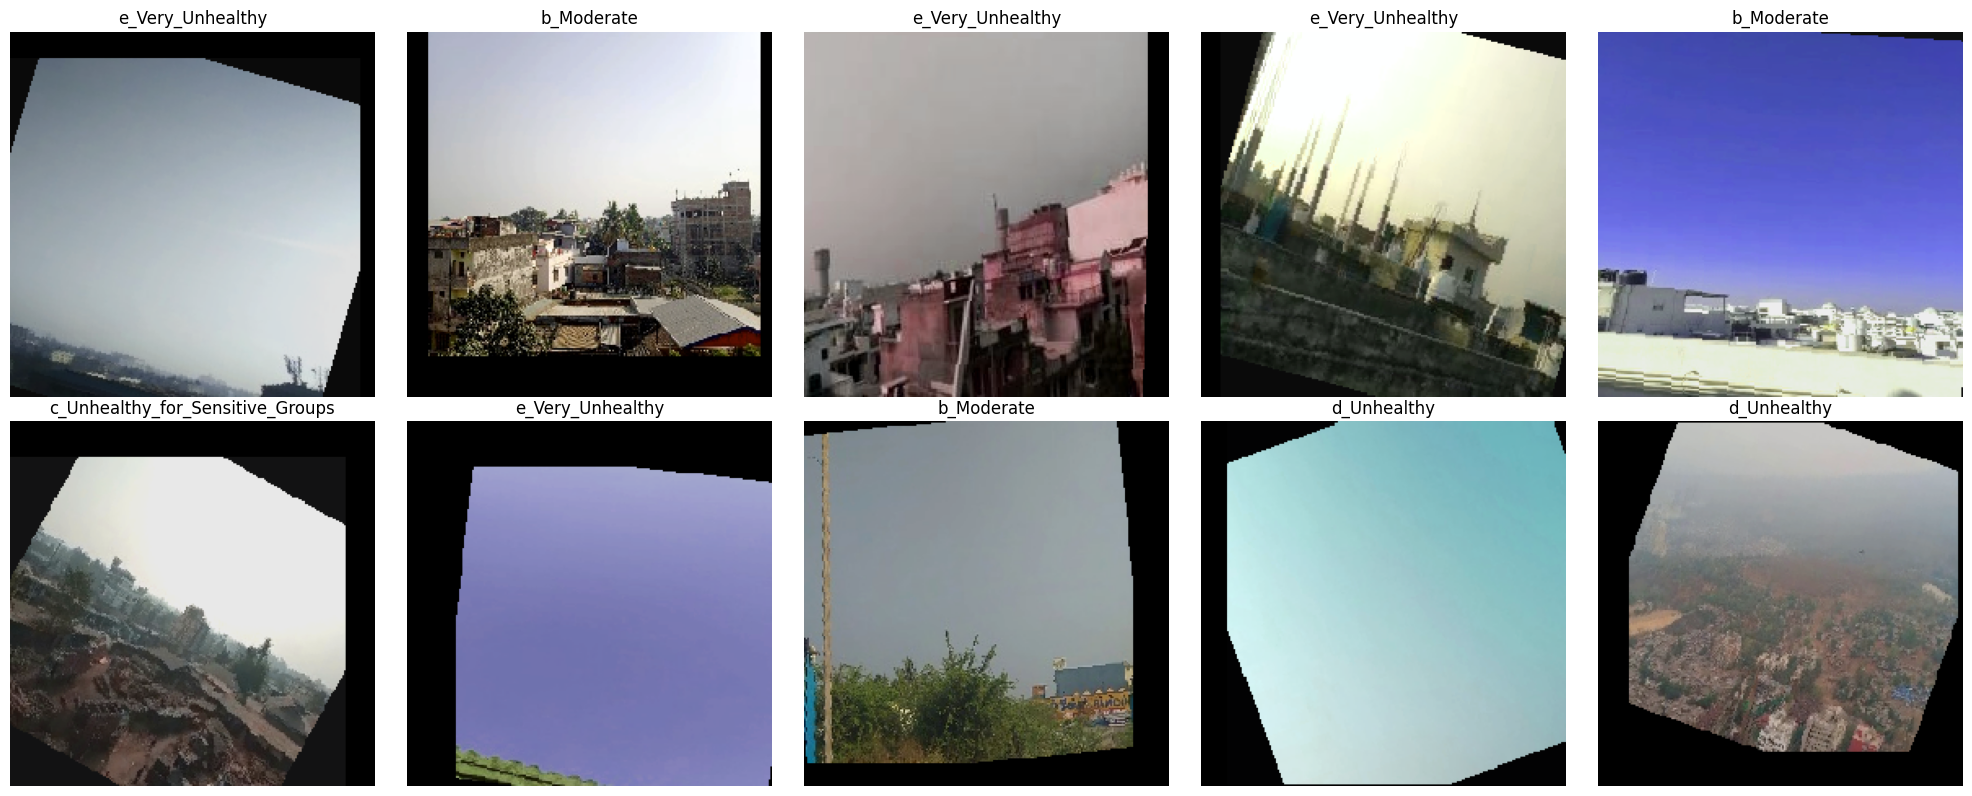

In [54]:
def show_images(dataset, num_images=10, rows=2):
    cols = int(np.ceil(num_images / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    indices = np.random.randint(0, len(dataset), size=num_images)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(inv_class_map[label])
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

show_images(train_dataset)


# 13. Image Size Distribution

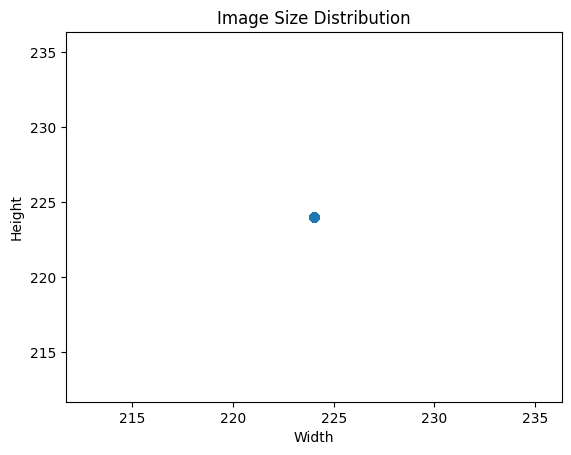

In [55]:
image_shapes = []
for p in train_df["image_path"]:
    with Image.open(p) as img:
        image_shapes.append(img.size)

image_shapes = np.array(image_shapes)

plt.scatter(image_shapes[:,0], image_shapes[:,1], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution")
plt.show()


#14. Pixel Intensity Distribution

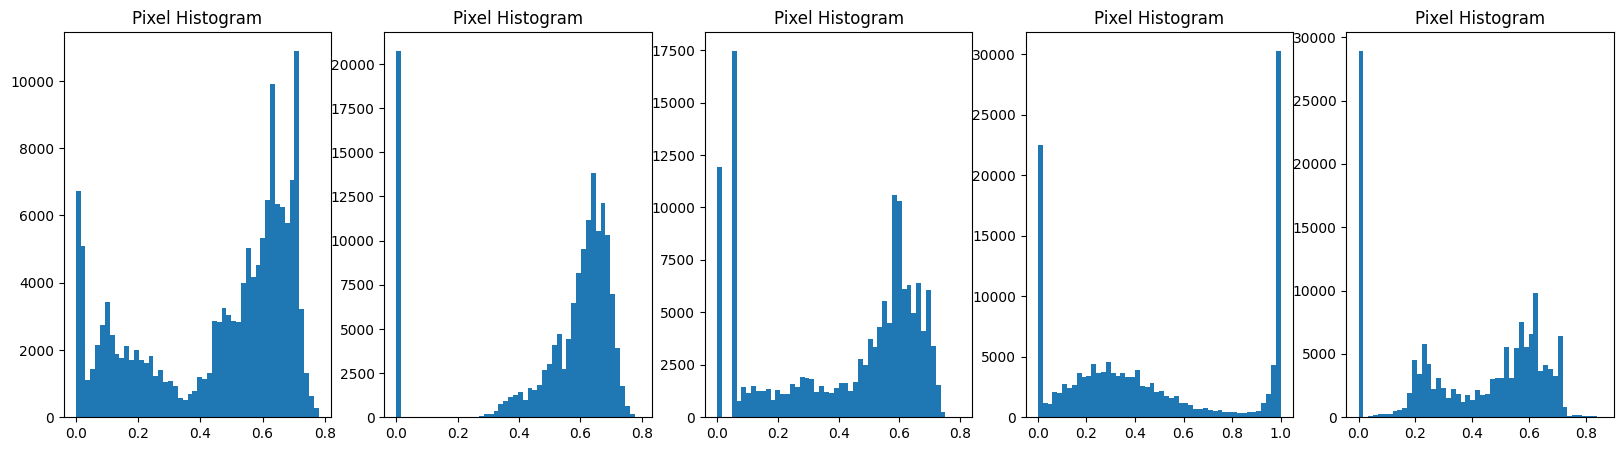

In [56]:
def plot_pixel_distribution(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20,5))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(num_samples):
        img,_ = dataset[i]
        img = img.permute(1,2,0).numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)
        axes[i].hist(img.ravel(), bins=50)
        axes[i].set_title("Pixel Histogram")

    plt.show()

plot_pixel_distribution(train_dataset)


# 15. Visualize Augmentations

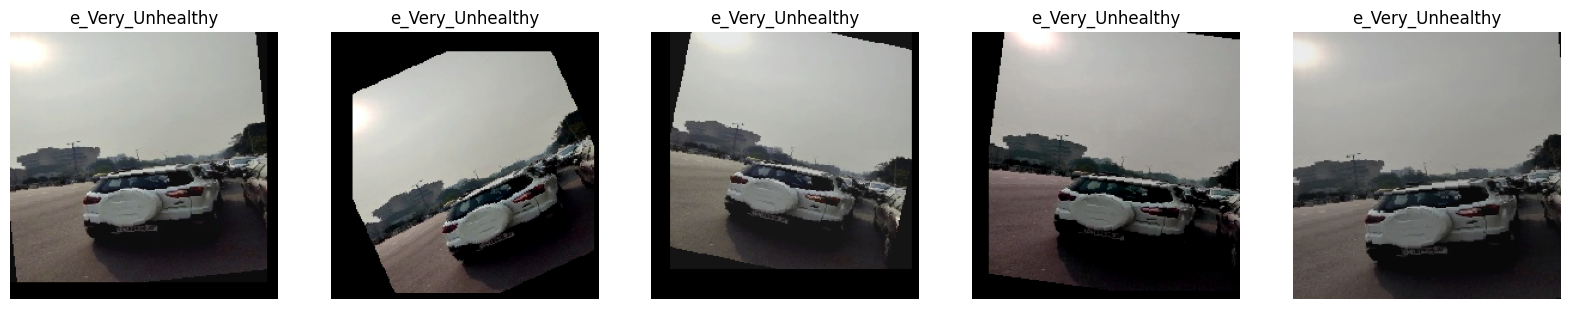

In [57]:
def visualize_augmentations(dataset, num_versions=5):
    idx = np.random.randint(len(dataset))
    img, label = dataset[idx]

    fig, axes = plt.subplots(1, num_versions, figsize=(20,4))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(num_versions):
        aug,_ = dataset[idx]
        aug = aug.permute(1,2,0).numpy()
        aug = aug * std + mean
        aug = np.clip(aug,0,1)
        axes[i].imshow(aug)
        axes[i].set_title(inv_class_map[label])
        axes[i].axis("off")

    plt.show()

visualize_augmentations(train_dataset)


# 16. Remove corrupted images

In [58]:
# Remove corrupted images
def filter_valid_images(df):
    valid = []
    for p in df["image_path"]:
        try:
            Image.open(p).verify()
            valid.append(True)
        except:
            valid.append(False)
    return df[valid]

train_df = filter_valid_images(train_df)
val_df = filter_valid_images(val_df)
